# Same problem/success as log_ret_many_indicators...

In [1]:
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
from ue.uexp.dataprocessing.ta import *
from ue.uexp.models.util import *

#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta
#=========================
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20, 10)

import warnings
warnings.filterwarnings('ignore')

# Introduction

We use MLP, multiple variables ([log_ret_0, ..., log_ret_29, volume, spread, log_price_change, ...] to predict -> log_return")

## Predicting on
- log_return of price at next timestep

## Data + preprocessing

In [2]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2022-02-03"
end_date = "2022-02-04"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-02.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-03.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-04.csv


In [3]:
df.drop(["tic"], axis=1, inplace=True)
df.columns = ["Open","High","Low","Close","Volume"]

## Adding TAs

#### Volatility Indicators

In [4]:
#df.head(50)

#### Momentum Indicators
- Rate of change (ROC)
- Relative Strenght Index (RSI)
- Stochastic RSI (sRSI, srsi_k, srsi_d)
- True Strength Index (TSI)

In [5]:
window = 30 # a choice
# df[f"roc_{window}"] = ta.momentum.ROCIndicator(close=df["Close"], window=window).roc()

# TSI Indicator
df["momentum_tsi"] = TSIIndicator(
    close=df["Close"], window_slow=25, window_fast=13, fillna=True
).tsi()/100 #scale 0-1

## Drop OHL, stationize C, and related

In [6]:
def stationize(series):
    return np.log(series / series.shift(1))

In [7]:
df.head()

,Open,High,Low,Close,Volume,momentum_tsi
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868,0.000000
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825,-1.000000
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231,-1.000000
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235,-0.871596
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702,-0.833150


In [8]:
# store initial price to reconstruct it back from returns
# initialprices = {
#     "Close": df['Close'][0],
#     "volume_vwap": ,
#     "trend_sma_slow",
#     "trend_ema_slow":
# }
# the initial price is at 00:00:00
df['log_ret'] = stationize(df['Close'])
# df['log_volume_vwap_ret'] = stationize(df['volume_vwap'])
# df['log_trend_sma_slow_ret'] = stationize(df['trend_sma_slow'])
# df['log_trend_ema_slow_ret'] = stationize(df['trend_ema_slow'])

In [9]:
df.drop(["Open","High","Low", "Volume"], axis=1, inplace=True)

In [10]:
#df.dropna(inplace=True)

## Make Windowed dataset (using dt_feats1)

In [11]:
HORIZON = 1
WINDOW = 30

In [12]:
# Add windowed columns
for i in range(WINDOW-1): # Shift values for each step in WINDOW_SIZE
  df[f"log_ret+{i+1}"] = df["log_ret"].shift(periods=i+2)
df.head(50)

,Close,momentum_tsi,log_ret,log_ret+1,log_ret+2,log_ret+3,log_ret+4,log_ret+5,log_ret+6,log_ret+7,...,log_ret+20,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29
2022-02-03 00:00:00,36902.96,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:01,36902.81,-1.000000,-4.064723e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:02,36899.19,-1.000000,-9.810032e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:03,36900.54,-0.871596,3.658550e-05,-4.064723e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:04,36895.62,-0.833150,-1.333403e-04,-9.810032e-05,-4.064723e-06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:05,36900.26,-0.600366,1.257523e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:06,36898.71,-0.504129,-4.200601e-05,-1.333403e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:07,36898.71,-0.450333,0.000000e+00,1.257523e-04,-1.333403e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:08,36898.71,-0.416051,0.000000e+00,-4.200601e-05,1.257523e-04,-1.333403e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:09,36896.07,-0.416555,-7.154978e-05,0.000000e+00,-4.200601e-05,1.257523e-04,-1.333403e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.dropna().shape

(172769, 32)

In [14]:
df.shape

(172800, 32)

In [15]:
#drop non-stationized values, keeping them for later reconstruction
X = df.dropna().drop(["Close"], axis=1).astype(np.float32) 

#note, starting at :30second
X.head()

,momentum_tsi,log_ret,log_ret+1,log_ret+2,log_ret+3,log_ret+4,log_ret+5,log_ret+6,log_ret+7,log_ret+8,...,log_ret+20,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29
2022-02-03 00:00:31,-0.326270,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000037,-0.000032,-0.000094,-0.000123,...,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133,0.000037,-0.000098,-0.000004
2022-02-03 00:00:32,-0.221396,0.000299,0.000373,0.000000,0.000000,0.000000,0.000000,-0.000037,-0.000032,-0.000094,...,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133,0.000037,-0.000098
2022-02-03 00:00:33,-0.144487,-0.000010,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000,-0.000037,-0.000032,...,-0.000259,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133,0.000037
2022-02-03 00:00:34,-0.083675,0.000010,0.000299,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000,-0.000037,...,0.000249,-0.000259,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133
2022-02-03 00:00:35,-0.031504,0.000027,-0.000010,0.000299,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000,...,-0.000151,0.000249,-0.000259,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126


In [16]:
X.shape

(172769, 31)

In [17]:
y = df.dropna().drop(["Close"], axis=1)["log_ret"].astype(np.float32)
y.head()

2022-02-03 00:00:31    0.000000
2022-02-03 00:00:32    0.000299
2022-02-03 00:00:33   -0.000010
2022-02-03 00:00:34    0.000010
2022-02-03 00:00:35    0.000027
Freq: S, Name: log_ret, dtype: float32

In [18]:
y.shape

(172769,)

## Train on all except last 3600s

In [19]:

# X_train, y_train = X[:-3600], y[:-3600]
# len(X_train), len(y_train)

### Train val test split: (first 60% training, next 20% validation, last 20% for evaluation)

In [20]:
# #train80%, validate 20%-1, test on last datapoint
# split_size_1 = int(len(X) * 0.8)
# X_train, y_train = X[:split_size_1], y[:split_size_1]
# X_val, y_val = X[split_size_1:-1], y[split_size_1:-1]
# X_test, y_test = X[-1:], y[-1:]
# len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

In [21]:
split_size_1 = int(len(X) * 0.6)
split_size_2 = int(len(X) * 0.8)
X_train, y_train = X[:split_size_1], y[:split_size_1]
X_val, y_val = X[split_size_1:split_size_2], y[split_size_1:split_size_2]
X_test, y_test = X[split_size_2:], y[split_size_2:]
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(103661, 103661, 34554, 34554, 34554, 34554)

## Model building and fitting

In [22]:
tf.keras.backend.clear_session()

In [23]:
# Make multivariate time series model
model_dense_multivariate = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_dense_multivariate")

# Compile
model_dense_multivariate.compile(loss="mae",
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=['mse','mape','mae'])

Metal device set to: Apple M1 Pro


2022-02-12 18:22:53.522661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-12 18:22:53.522794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
# Fit
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=2,
#                                                     mode='min')

history = model_dense_multivariate.fit(X_train, y_train,
                                       epochs=20, #saw that 20 was good enough
                                       batch_size=128,
                                       shuffle=True,
                                       verbose=1, # progress bar
                                       validation_data=(X_val, y_val),
                                       callbacks=[create_model_checkpoint(model_name=model_dense_multivariate.name),
                                                 ])

2022-02-12 18:22:53.581709: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/20


2022-02-12 18:22:53.743044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


810/810 [==============================] - ETA: 0s - loss: 6.9241e-04 - mse: 1.8176e-06 - mape: 225042.2500 - mae: 6.9241e-04

2022-02-12 18:22:59.004203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
810/810 [==============================] - 7s 8ms/step - loss: 6.9241e-04 - mse: 1.8176e-06 - mape: 225042.2500 - mae: 6.9241e-04 - val_loss: 6.5180e-04 - val_mse: 6.8301e-07 - val_mape: 236862.8906 - val_mae: 6.5180e-04
Epoch 2/20
  1/810 [..............................] - ETA: 5s - loss: 5.3050e-04 - mse: 5.2807e-07 - mape: 167805.0625 - mae: 5.3050e-04

2022-02-12 18:22:59.934039: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


810/810 [==============================] - 6s 8ms/step - loss: 2.1358e-04 - mse: 9.8075e-08 - mape: 66752.3516 - mae: 2.1358e-04 - val_loss: 1.5837e-04 - val_mse: 4.0100e-08 - val_mape: 53250.7695 - val_mae: 1.5837e-04
Epoch 3/20
810/810 [==============================] - 6s 8ms/step - loss: 1.5314e-04 - mse: 5.0009e-08 - mape: 46264.8906 - mae: 1.5314e-04 - val_loss: 8.2602e-05 - val_mse: 1.7090e-08 - val_mape: 21301.3223 - val_mae: 8.2602e-05
Epoch 4/20
810/810 [==============================] - 6s 7ms/step - loss: 1.2197e-04 - mse: 2.8015e-08 - mape: 35299.8398 - mae: 1.2197e-04 - val_loss: 1.1730e-04 - val_mse: 4.8210e-08 - val_mape: 37035.1211 - val_mae: 1.1730e-04
Epoch 5/20
810/810 [==============================] - 6s 8ms/step - loss: 1.0444e-04 - mse: 1.9810e-08 - mape: 29283.6719 - mae: 1.0444e-04 - val_loss: 1.7242e-04 - val_mse: 3.6212e-08 - val_mape: 58498.2969 - val_mae: 1.7242e-04
Epoch 6/20
810/810 [==============================] - 6s 8ms/step - loss: 9.5181e-05 - mse:

In [25]:
# model_dense_multivariate.save('dense_mlp')

In [26]:
model_dense_multivariate.summary()

Model: "model_dense_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4096      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,737
Trainable params: 20,737
Non-trainable params: 0
_________________________________________________________________


In [27]:
import pydot

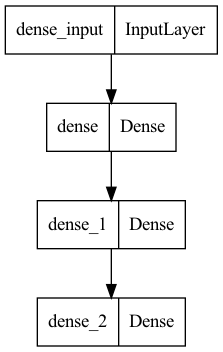

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model_dense_multivariate)

## Examining Histories

In [29]:
import matplotlib.pyplot as plt

In [30]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'mape', 'mae', 'val_loss', 'val_mse', 'val_mape', 'val_mae'])


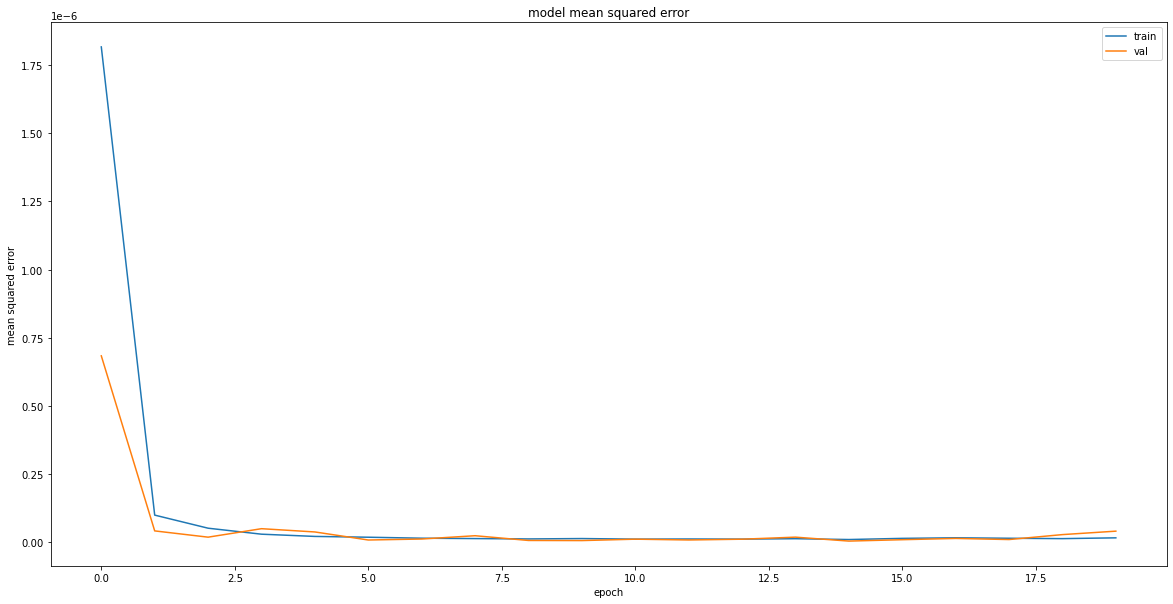

In [31]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

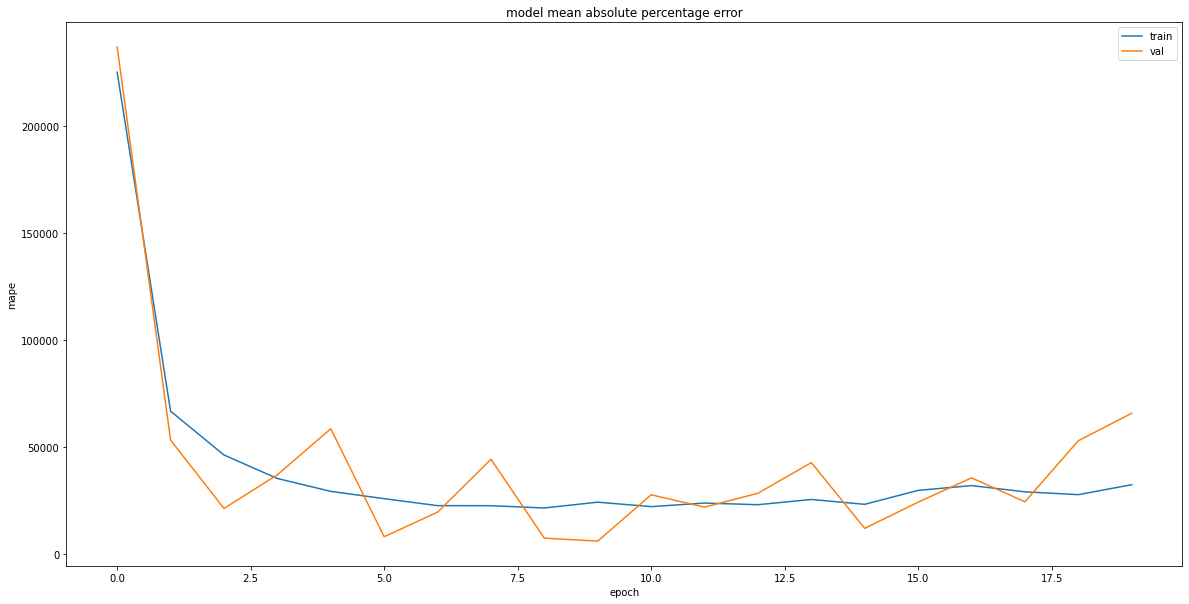

In [32]:
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mean absolute percentage error')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### insights
This model learns quite well 20 epochs in

## Evaluating model on new (unseen data)
should be the %age off of predicting the horizon price

In [33]:
# # Make sure best model is loaded and evaluate
# model_dense_multivariate = tf.keras.models.load_model("model_experiments/model_dense_multivariate")
# loss = model_dense_multivariate.evaluate(X_test, y_test)

In [34]:
# percentage
y_pred = model_dense_multivariate.predict(X_test)

2022-02-12 18:24:57.613962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [35]:
type(y_pred)

numpy.ndarray

In [36]:
y_pred

array([[0.00020618],
       [0.00020761],
       [0.00015342],
       ...,
       [0.0001365 ],
       [0.00026475],
       [0.00039828]], dtype=float32)

In [37]:
y_test = np.array(y_test)

In [38]:
type(y_test)

numpy.ndarray

In [39]:
y_test

array([ 5.7333345e-05,  5.2818090e-05, -5.3348940e-05, ...,
       -7.7742166e-05,  1.4537053e-04,  5.3484901e-04], dtype=float32)

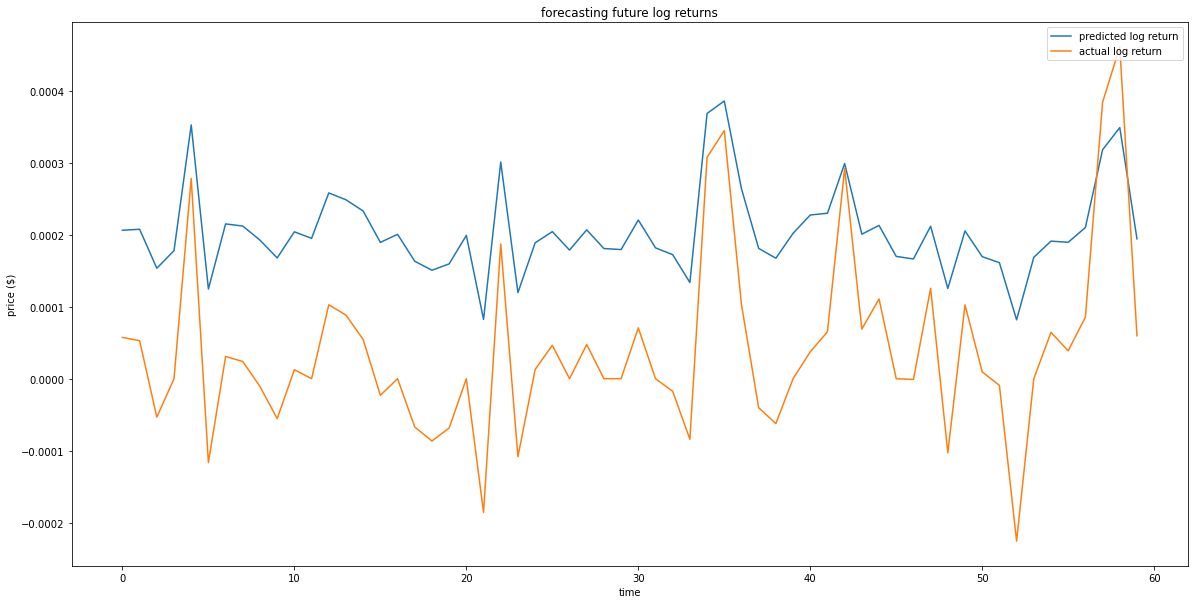

In [40]:
plt.plot(y_pred[:60], label="predicted log return")
plt.plot(y_test[:60], label="actual log return")
plt.title('forecasting future log returns')
plt.ylabel('price ($)')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.show()

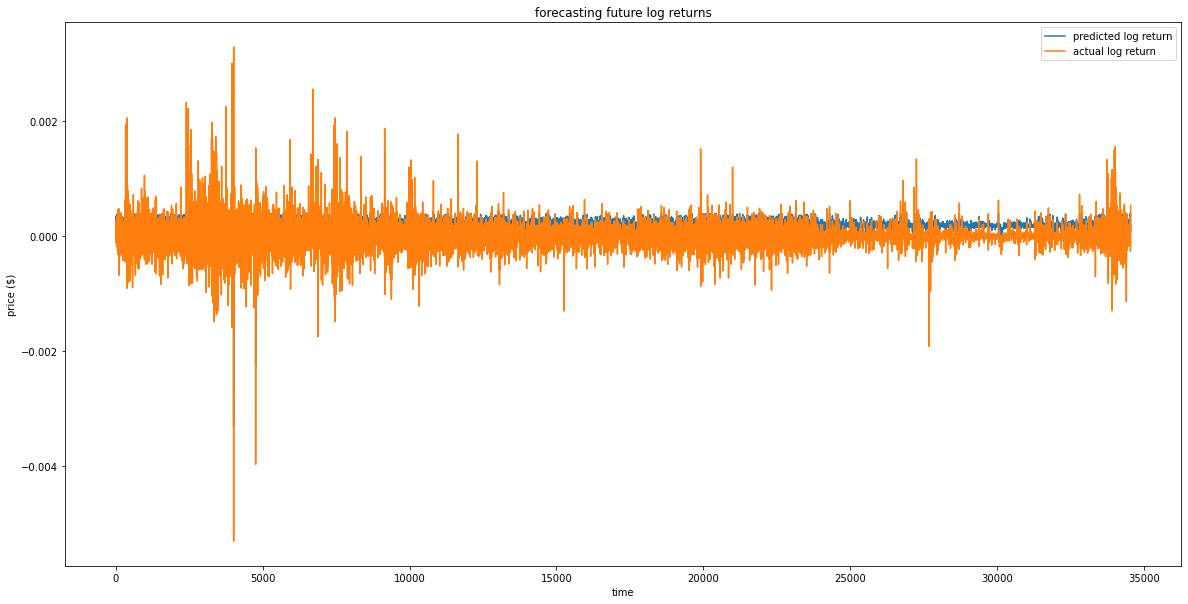

In [41]:
plt.plot(y_pred, label="predicted log return")
plt.plot(y_test, label="actual log return")
plt.title('forecasting future log returns')
plt.ylabel('price ($)')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.show()

In [42]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

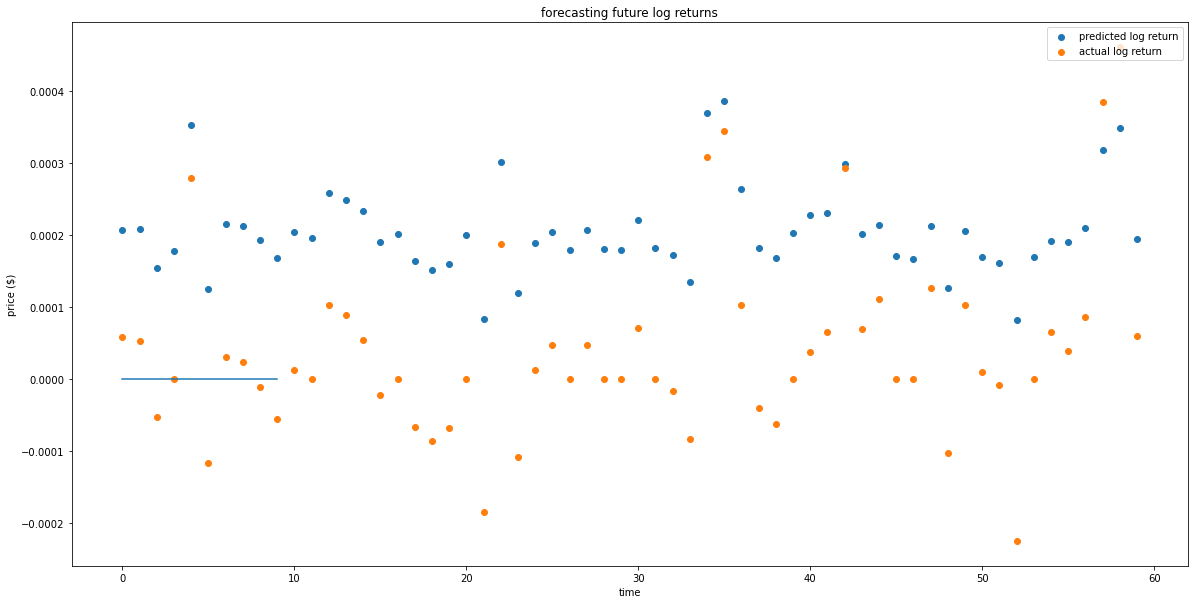

In [43]:
plt.scatter(x=np.arange(60), y=y_pred[:60], label="predicted log return",)
plt.scatter(x=np.arange(60), y=y_test[:60], label="actual log return")
plt.plot(np.zeros(10))
plt.title('forecasting future log returns')
plt.ylabel('price ($)')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.show()

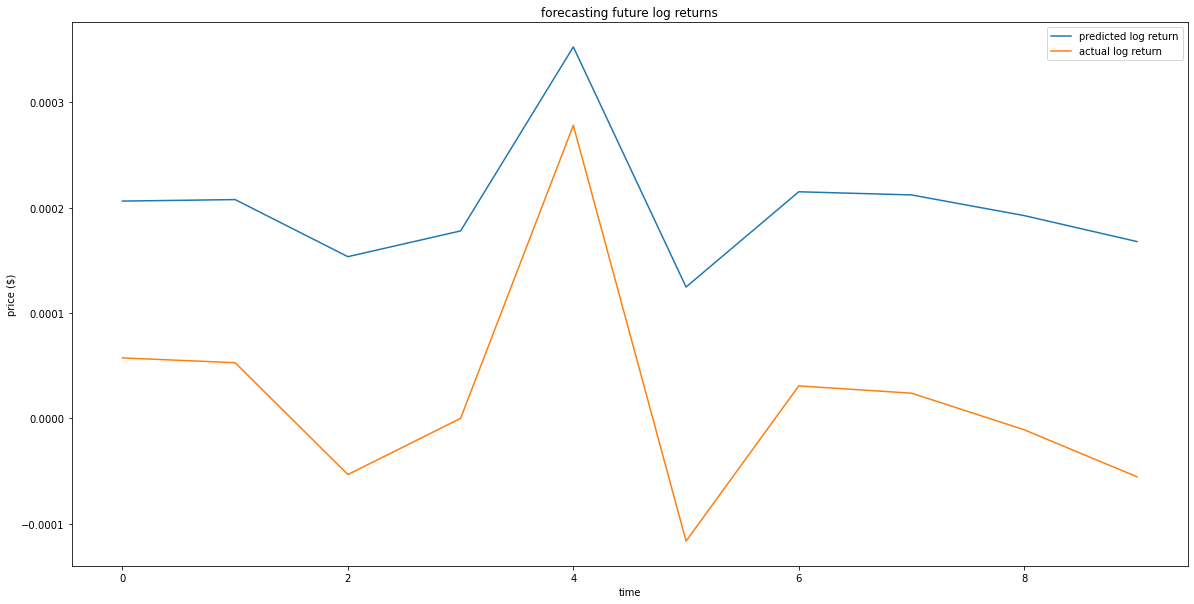

In [44]:
plt.plot(y_pred[:10], label="predicted log return",)
plt.plot(y_test[:10], label="actual log return")
plt.title('forecasting future log returns')
plt.ylabel('price ($)')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.show()

## Go from log returns back to price

initial price should be price at X_test.timestamp-1

In [45]:
p_0 = X_test

In [46]:
# 1 step back as p_initial
p_0_time = X_test.index[0] - pd.Timedelta(X_test.index[0].freq)

In [47]:
p_0_test = df.loc[p_0_time]['Close']

### The price should be initial_price * exp(log_ret.cumsum())

In [48]:
tot_return_pct = y_pred.cumsum()
tot_return_pct

array([2.0618197e-04, 4.1379052e-04, 5.6721485e-04, ..., 6.4757152e+00,
       6.4759798e+00, 6.4763780e+00], dtype=float32)

In [49]:
y_pred_prices = p_0_test*np.exp(y_pred.cumsum())

In [50]:
y_actual_prices = p_0_test*np.exp(y_test.cumsum())

In [51]:
len(y_pred_prices), len(y_actual_prices)

(34554, 34554)

In [52]:
y_pred_prices[:500]

array([37681.098, 37688.92 , 37694.7  , 37701.41 , 37714.7  , 37719.402,
       37727.51 , 37735.51 , 37742.773, 37749.105, 37756.81 , 37764.17 ,
       37773.918, 37783.305, 37792.105, 37799.266, 37806.848, 37813.016,
       37818.71 , 37824.742, 37832.273, 37835.39 , 37846.78 , 37851.3  ,
       37858.45 , 37866.18 , 37872.945, 37880.777, 37887.63 , 37894.426,
       37902.777, 37909.67 , 37916.203, 37921.273, 37935.242, 37949.883,
       37959.895, 37966.766, 37973.12 , 37980.79 , 37989.42 , 37998.16 ,
       38009.516, 38017.145, 38025.242, 38031.703, 38038.03 , 38046.086,
       38050.85 , 38058.664, 38065.12 , 38071.254, 38074.367, 38080.79 ,
       38088.062, 38095.285, 38103.285, 38115.406, 38128.703, 38136.11 ,
       38143.055, 38149.766, 38152.555, 38162.082, 38163.67 , 38170.312,
       38177.27 , 38183.414, 38193.23 , 38200.684, 38207.273, 38219.457,
       38230.645, 38239.207, 38246.15 , 38253.676, 38265.414, 38274.812,
       38278.438, 38287.766, 38294.832, 38299.28 , 

In [53]:
y_actual_prices

array([37675.49 , 37677.477, 37675.47 , ..., 41545.98 , 41552.016,
       41574.246], dtype=float32)

In [54]:
df['Close'][-10:]

2022-02-04 23:59:50    41559.41
2022-02-04 23:59:51    41559.41
2022-02-04 23:59:52    41560.00
2022-02-04 23:59:53    41560.00
2022-02-04 23:59:54    41556.62
2022-02-04 23:59:55    41545.77
2022-02-04 23:59:56    41549.21
2022-02-04 23:59:57    41545.98
2022-02-04 23:59:58    41552.02
2022-02-04 23:59:59    41574.25
Freq: S, Name: Close, dtype: float64

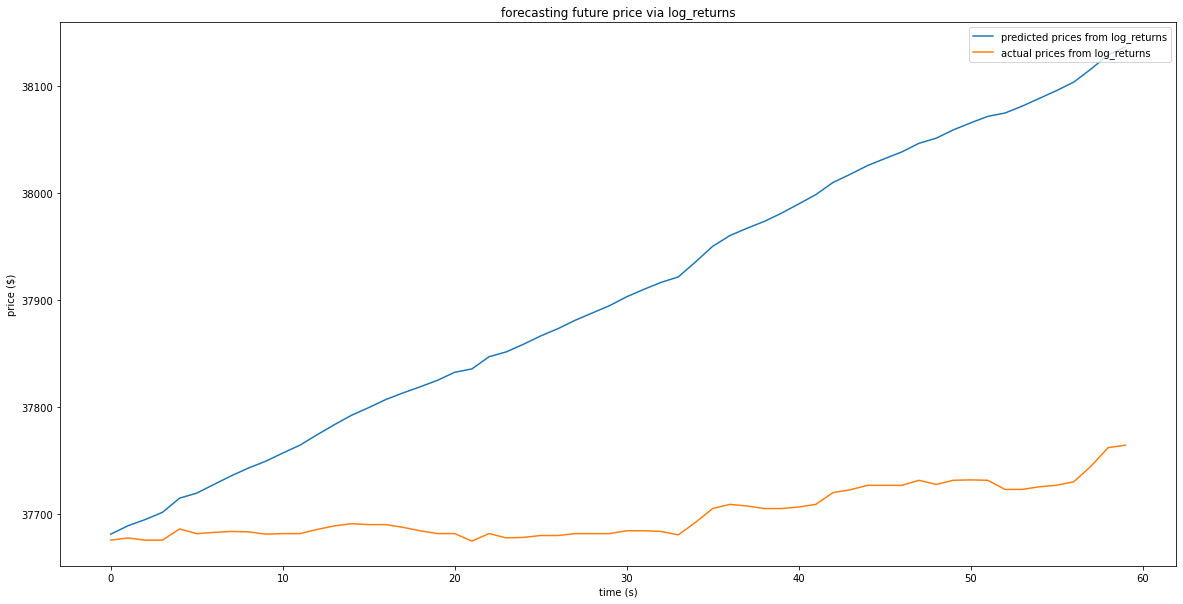

In [55]:
plt.plot(y_pred_prices[:60], label="predicted prices from log_returns")
plt.plot(y_actual_prices[:60], label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()

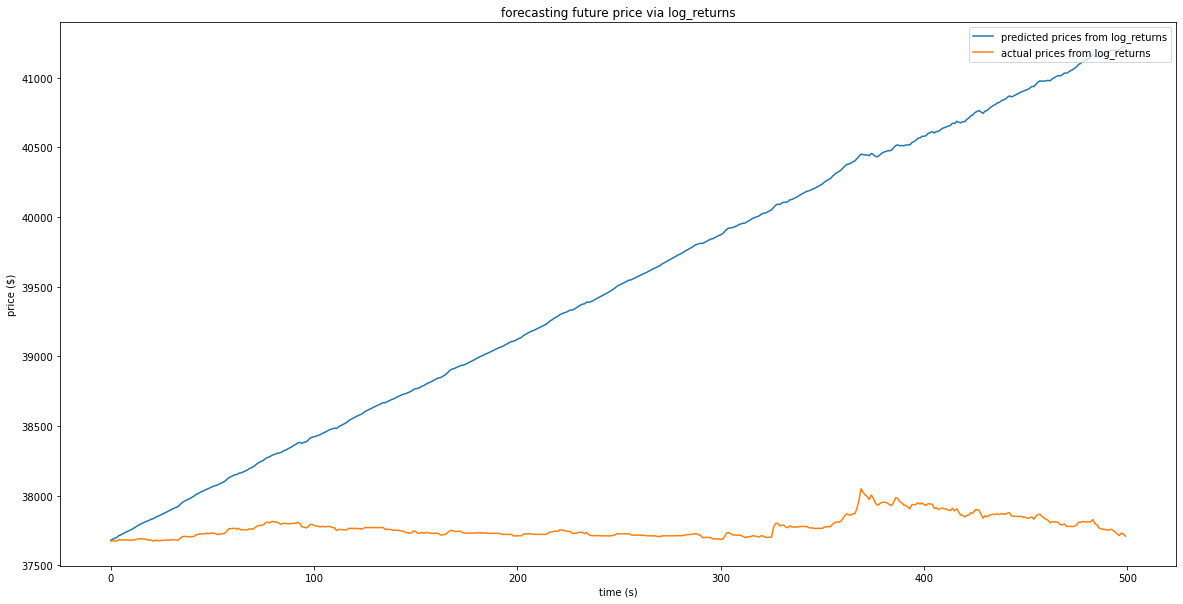

In [56]:
plt.plot(y_pred_prices[:500], label="predicted prices from log_returns")
plt.plot(y_actual_prices[:500], label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()

### Observation: is okay for the first bit of data beyond train/val set, approx 50seconds, afterwards it flies!

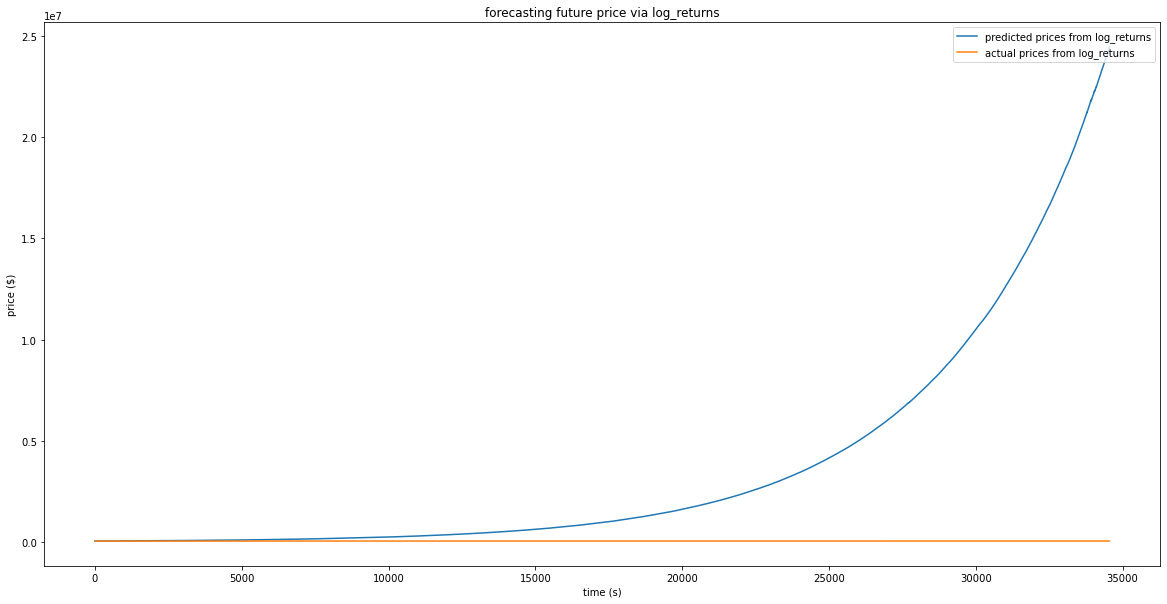

In [57]:
# for example, on the whole testing set
plt.plot(y_pred_prices, label="predicted prices from log_returns")
plt.plot(y_actual_prices, label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()

In [58]:
# percentage
y_pred_2 = model_dense_multivariate.predict(X_test[3600:])

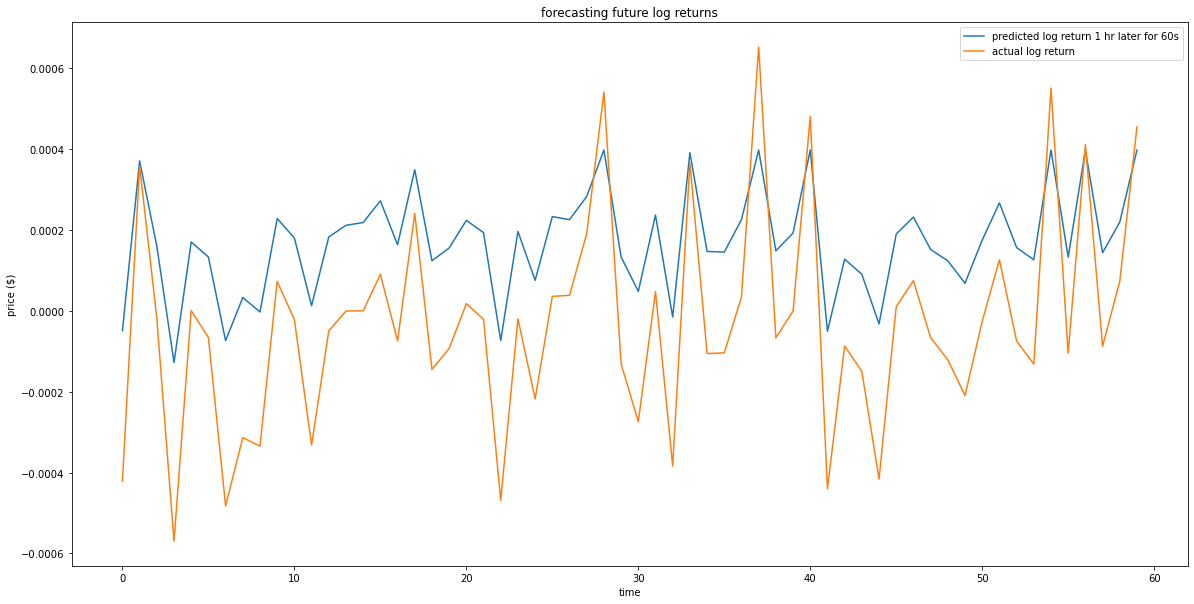

In [59]:
plt.plot(y_pred_2[:60], label="predicted log return 1 hr later for 60s")
plt.plot(y_test[3600:3660], label="actual log return")
plt.title('forecasting future log returns')
plt.ylabel('price ($)')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.show()